#### Oğuz Deniz 201401011
##### YAP441 Project - GARCH Notebook

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from arch import arch_model
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    confusion_matrix, 
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

In [58]:
class StockGARCHPredictor:
    def __init__(self, p=1, q=1):
        self.p = p
        self.q = q
        self.scaler = StandardScaler()
        self.model = None
        self.fitted_model = None

    def clean_data(self, data):
        # Remove rows with NaN or infinite values
        cleaned_data = data.copy()
        cleaned_data = cleaned_data.replace([np.inf, -np.inf], np.nan)
        cleaned_data = cleaned_data.dropna()
        return cleaned_data

    def prepare_data(self, data):
        # Clean data first
        data = self.clean_data(data)

        # Ensure Date is datetime and set as index if needed
        if 'Date' in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

        # Calculate returns
        data['Returns'] = data['Adj Close'].pct_change()
        
        # Remove any NaN values resulting from returns calculation
        data = data.dropna()

        # Scale returns
        returns_scaled = self.scaler.fit_transform(data['Returns'].values.reshape(-1, 1)).flatten()

        return returns_scaled, data

    def prepare_weekly_data(self, data):
        # Clean data first
        data = self.clean_data(data)

        # Ensure Date is datetime
        data['Date'] = pd.to_datetime(data['Date'])

        # Resample to weekly data
        weekly_data = data.set_index('Date').resample('W').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        }).dropna()

        return self.prepare_data(weekly_data)

    def train(self, returns, prediction_type="daily"):
        # Unscale returns
        original_returns = self.scaler.inverse_transform(returns.reshape(-1, 1)).flatten()

        # Remove any NaN or infinite values
        original_returns = original_returns[np.isfinite(original_returns)]

        # Fit GARCH model
        if prediction_type == "daily":
            self.model = arch_model(original_returns, vol='Garch', p=self.p, q=self.q, rescale=True)
        else:  # weekly
            self.model = arch_model(original_returns, vol='Garch', p=1, q=1, rescale=True)  # More conservative for weekly

        self.fitted_model = self.model.fit(disp='off')  # Suppress output

    def predict_volatility(self, returns):
        """
        Predict volatility and return probabilities with directional prediction.
        The key fix here is to base the predicted_direction on our volatility forecast,
        rather than directly using the observed returns.
        """
        # Unscale returns
        original_returns = self.scaler.inverse_transform(returns.reshape(-1, 1)).flatten()

        # Remove any NaN or infinite values
        original_returns = original_returns[np.isfinite(original_returns)]

        # Forecast volatility (using a one-step-ahead forecast)
        forecast = self.fitted_model.forecast(horizon=1)
        # Take the square root of the variance forecast to get standard deviation
        volatility_forecast = forecast.variance.values[-1][0]**0.5

        # Compute the mean and standard deviation of the historical (original) returns
        volatility_mean = np.mean(original_returns)
        volatility_std = np.std(original_returns)

        # Define thresholds for volatility states
        low_volatility = volatility_mean - volatility_std
        high_volatility = volatility_mean + volatility_std

        # Determine the predicted state, directional prediction and confidence
        if volatility_forecast <= low_volatility:
            predicted_state = "Low Volatility"
            direction = "Up"
            confidence = 0.6
            # Predict 'Up' (1) for all test samples
            predicted_direction = np.ones_like(original_returns, dtype=int)
        elif volatility_forecast >= high_volatility:
            predicted_state = "High Volatility"
            direction = "Down"
            confidence = 0.6
            # Predict 'Down' (0) for all test samples
            predicted_direction = np.zeros_like(original_returns, dtype=int)
        else:
            predicted_state = "Medium Volatility"
            direction = "Neutral"
            confidence = 0.4
            # For Neutral, you might choose a default; here we use the overall sign of the mean return
            default_prediction = 1 if volatility_mean >= 0 else 0
            predicted_direction = np.full_like(original_returns, default_prediction, dtype=int)

        return (direction, confidence, volatility_forecast, 
                predicted_state, predicted_direction)


In [59]:
class StockGARCHVisualizer:
    @staticmethod
    def plot_volatility_and_returns(df_test, volatility_forecast, prediction_type, p, q):

        plt.figure(figsize=(15, 10))
        
        # Plot 1: Adjusted Close Price
        plt.subplot(2, 2, 1)
        plt.plot(df_test.index, df_test['Adj Close'], label='Adjusted Close')
        plt.title(f'{prediction_type.capitalize()} Adjusted Close Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        
        # Plot 2: Returns
        plt.subplot(2, 2, 2)
        returns = df_test['Returns']
        plt.plot(df_test.index, returns, label='Returns', color='blue')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'{prediction_type.capitalize()} Returns (GARCH p={p}, q={q})')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        
        # Plot 3: Returns Distribution
        plt.subplot(2, 2, 3)
        sns.histplot(returns, kde=True)
        plt.title('Returns Distribution')
        plt.xlabel('Returns')
        plt.ylabel('Frequency')
        
        # Plot 4: Volatility Comparison
        plt.subplot(2, 2, 4)
        rolling_volatility = returns.rolling(window=30).std()
        plt.plot(df_test.index, rolling_volatility, label='Rolling Volatility')
        plt.axhline(y=volatility_forecast, color='r', linestyle='--', label='Forecast Volatility')
        plt.title('Rolling Volatility vs Forecast')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_accuracy_metrics(actual_returns, predicted_direction):
        # Convert returns to binary direction (1 for up, 0 for down)
        actual_direction = (actual_returns > 0).astype(int)
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Confusion Matrix
        plt.subplot(2, 2, 1)
        cm = confusion_matrix(actual_direction, predicted_direction)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        
        # Plot 2: Classification Report Visualization
        plt.subplot(2, 2, 2)
        class_report = classification_report(actual_direction, predicted_direction, output_dict=True)
        report_df = pd.DataFrame(class_report).transpose()
        sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
        plt.title('Classification Report Heatmap')
        
        # Plot 3: Accuracy Over Time
        plt.subplot(2, 2, 3)
        rolling_accuracy = pd.Series(actual_direction == predicted_direction).rolling(window=30).mean()
        plt.plot(rolling_accuracy.index, rolling_accuracy, label='Rolling Accuracy')
        plt.title('Rolling Prediction Accuracy')
        plt.xlabel('Date')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot 4: Directional Accuracy Comparison
        plt.subplot(2, 2, 4)
        direction_counts = pd.Series({
            'Correct Up': np.sum((actual_direction == 1) & (predicted_direction == 1)),
            'Incorrect Up': np.sum((actual_direction == 1) & (predicted_direction == 0)),
            'Correct Down': np.sum((actual_direction == 0) & (predicted_direction == 0)),
            'Incorrect Down': np.sum((actual_direction == 0) & (predicted_direction == 1))
        })
        direction_counts.plot(kind='bar')
        plt.title('Prediction Directional Accuracy')
        plt.xlabel('Prediction Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()

In [60]:
def evaluate_garch_predictions(data, prediction_type="daily", p=1, q=1, 
                                test_size=0.2, visualize=True):
    """
    Comprehensive GARCH model evaluation with visualizations
    """
    # Initialize GARCH predictor
    predictor = StockGARCHPredictor(p=p, q=q)
    visualizer = StockGARCHVisualizer()
    
    # Prepare data based on prediction type
    if prediction_type == "weekly":
        returns, df = predictor.prepare_weekly_data(data)
    else:
        returns, df = predictor.prepare_data(data)
    
    # Split data
    train_size = int(len(returns) * (1 - test_size))
    returns_train, returns_test = returns[:train_size], returns[train_size:]
    df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Train model
    predictor.train(returns_train, prediction_type)
    
    # Predict for test set
    direction, confidence, volatility_forecast, volatility_state, predicted_direction = \
        predictor.predict_volatility(returns_test)
    
    # Calculate performance metrics
    actual_returns = df_test['Returns'].values
    forecast_array = np.full_like(actual_returns, volatility_forecast)
    
    # Calculate metrics
    mse = mean_squared_error(actual_returns, forecast_array)
    mae = mean_absolute_error(actual_returns, forecast_array)
    
    # Binary direction prediction metrics
    actual_direction = (actual_returns > 0).astype(int)
    accuracy = accuracy_score(actual_direction, predicted_direction)
    
    # Print results
    print(f"\nResults for {prediction_type.capitalize()} GARCH Prediction (p={p}, q={q}):")
    print(f"Predicted Direction: {direction}")
    print(f"Volatility State: {volatility_state}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Directional Accuracy: {accuracy:.2%}")
    
    # Visualizations
    if visualize:
        # Volatility and Returns Visualization
        visualizer.plot_volatility_and_returns(
            df_test, volatility_forecast, prediction_type, p, q
        )
        
        # Accuracy Metrics Visualization
        visualizer.plot_accuracy_metrics(
            actual_returns, predicted_direction
        )
    
    return {
        'predictor': predictor,
        'direction': direction,
        'confidence': confidence,
        'volatility_forecast': volatility_forecast,
        'volatility_state': volatility_state,
        'mse': mse,
        'mae': mae,
        'accuracy': accuracy
    }

In [61]:
def run_garch_experiments(data):
    """
    Run GARCH experiments with different parameters
    """
    garch_results = {}
    
    # Daily predictions with different GARCH parameters
    for p, q in [(1, 1), (1, 2), (2, 1)]:
        garch_results[f'daily_p{p}_q{q}'] = evaluate_garch_predictions(
            data, 
            prediction_type="daily", 
            p=p, 
            q=q
        )
    
    # Weekly predictions with different GARCH parameters
    for p, q in [(1, 1), (1, 2), (2, 1)]:
        garch_results[f'weekly_p{p}_q{q}'] = evaluate_garch_predictions(
            data, 
            prediction_type="weekly", 
            p=p, 
            q=q
        )
    
    return garch_results

In [62]:
def plot_garch_accuracies(garch_results):
    """
    Print and plot the accuracy values of all GARCH models.
    """
    # Extract model names and their corresponding accuracy values.
    model_names = list(garch_results.keys())
    accuracies = [result['accuracy'] for result in garch_results.values()]

    # Print the accuracy for each model.
    print("GARCH Model Accuracies:")
    for name, acc in zip(model_names, accuracies):
        print(f"{name}: {acc:.2%}")

    # Plot the accuracies using a bar chart.
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='skyblue')
    plt.ylabel("Accuracy")
    plt.xlabel("GARCH Model")
    plt.title("Accuracy of Different GARCH Models")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


Results for Daily GARCH Prediction (p=1, q=1):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.0251
Mean Absolute Error: 0.1565
Directional Accuracy: 48.79%


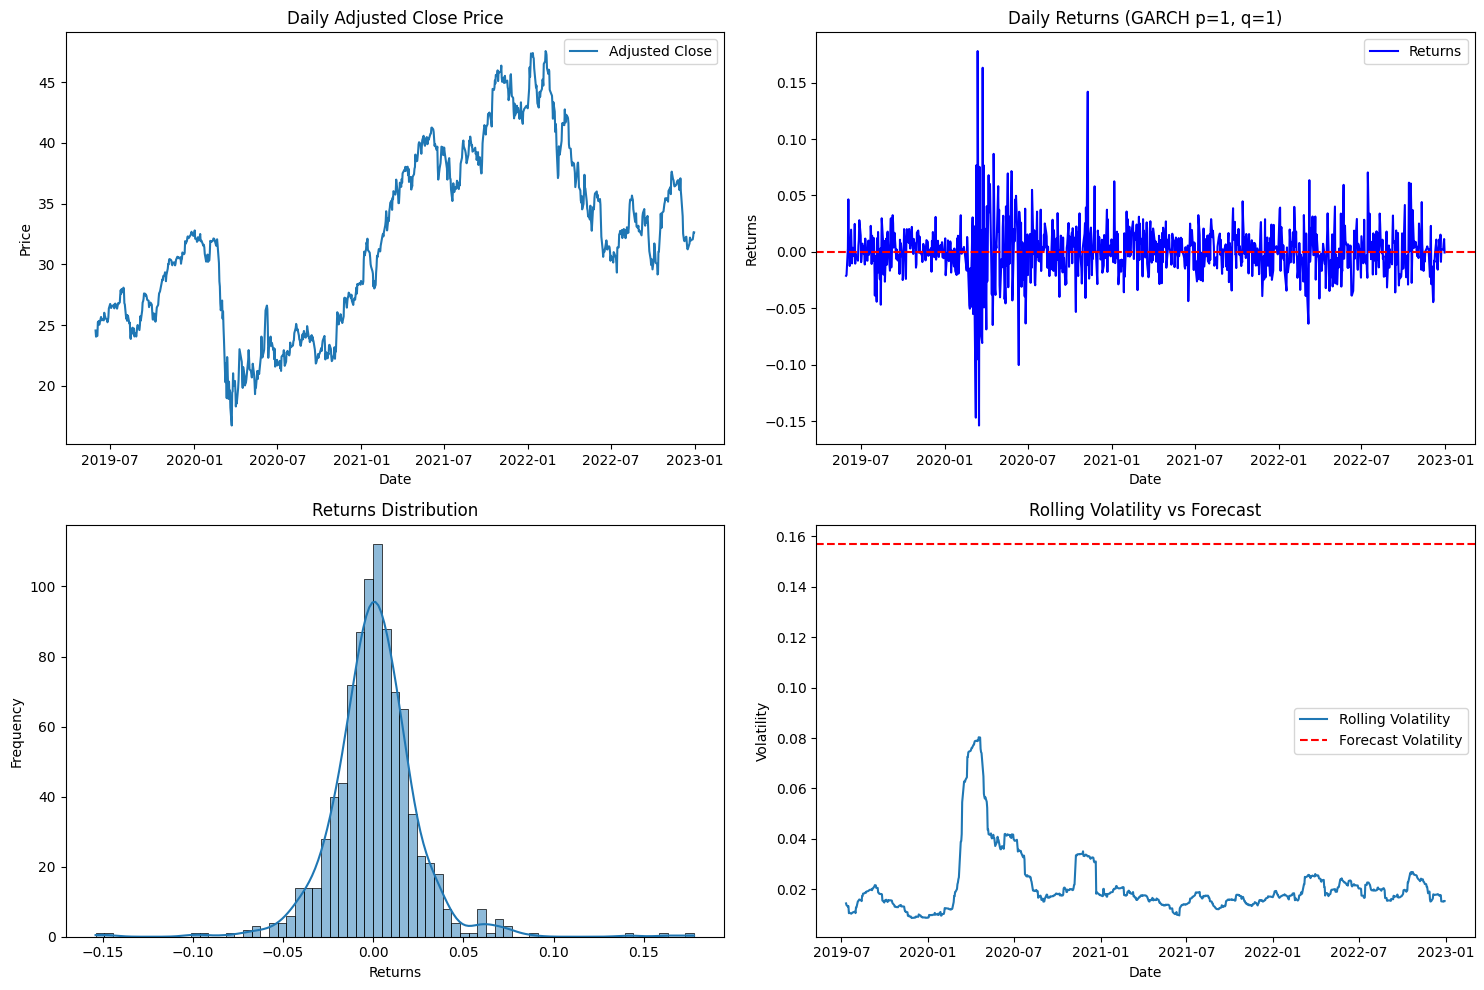

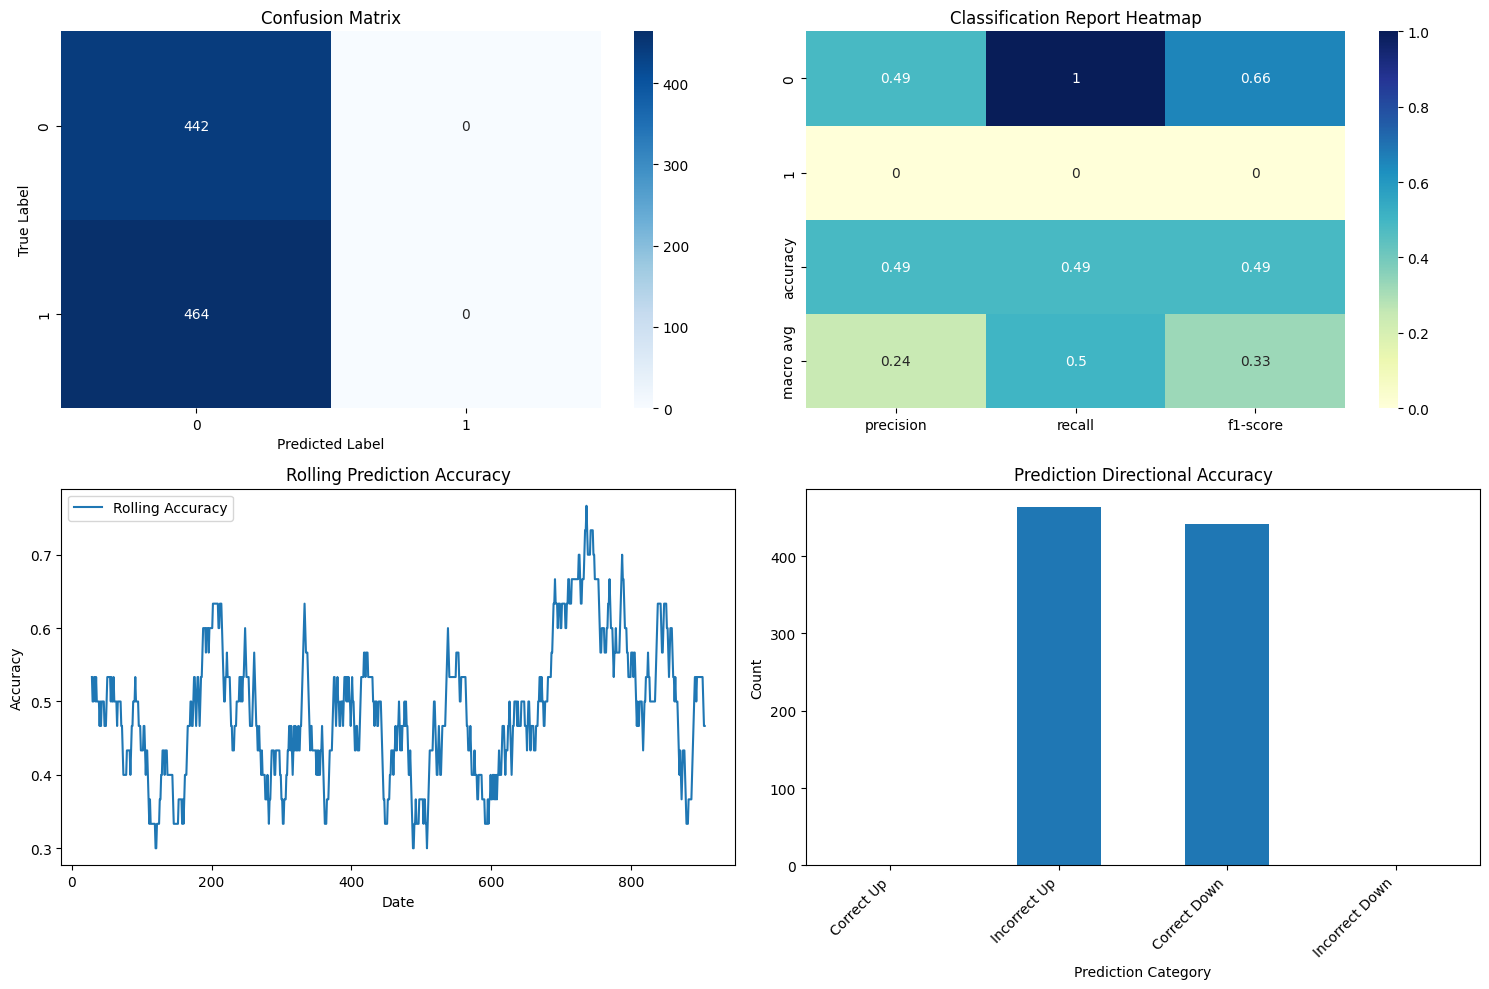


Results for Daily GARCH Prediction (p=1, q=2):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.0239
Mean Absolute Error: 0.1526
Directional Accuracy: 48.79%


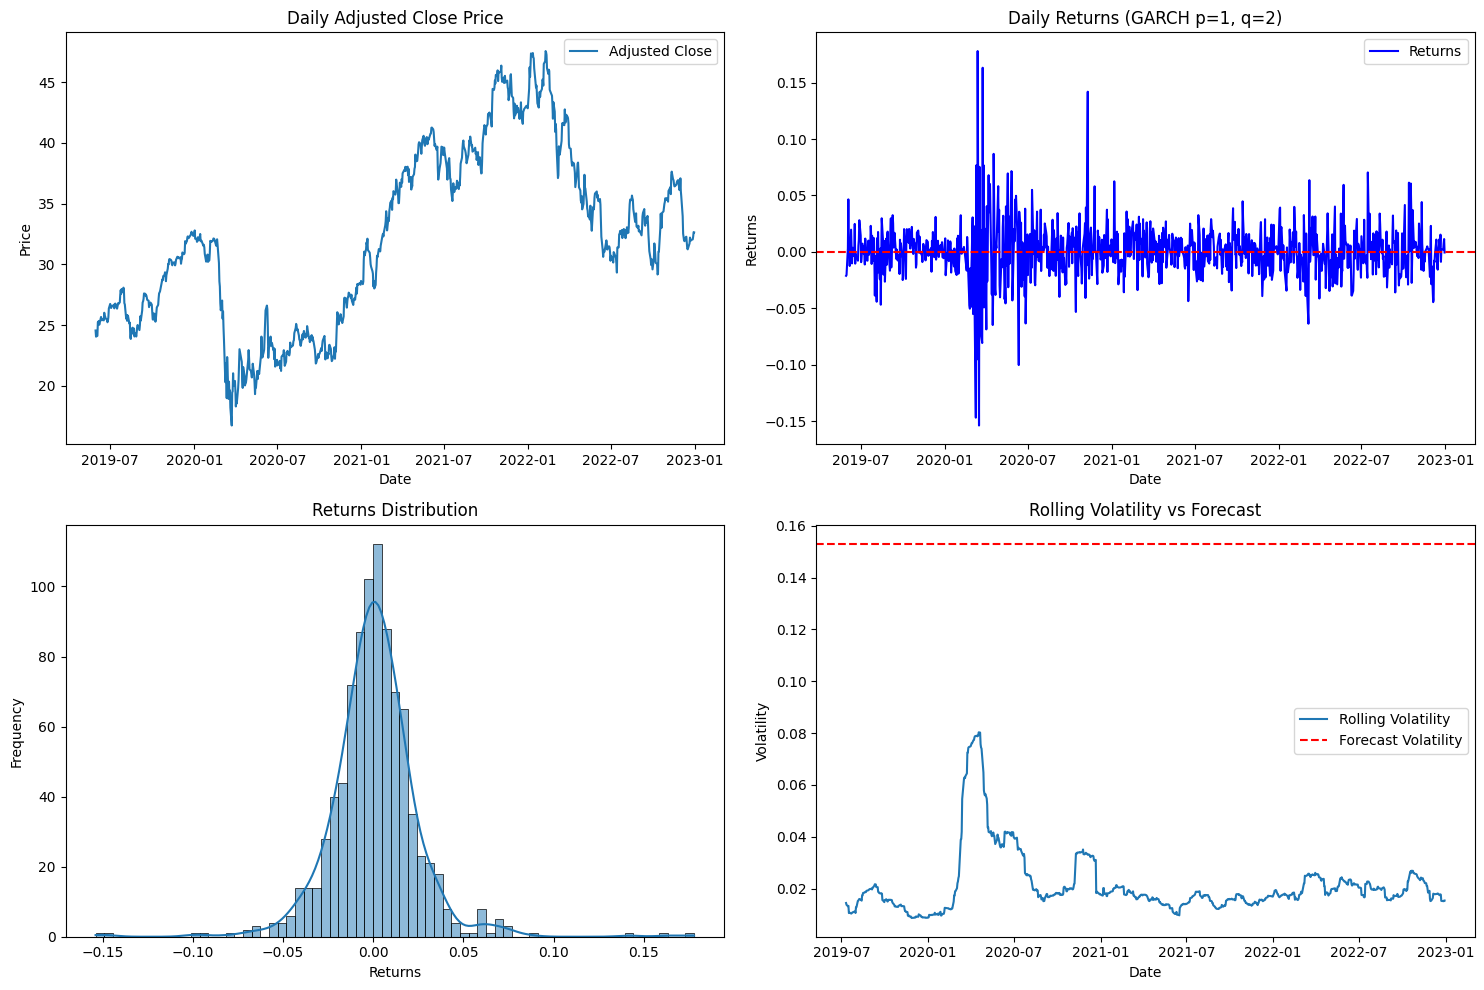

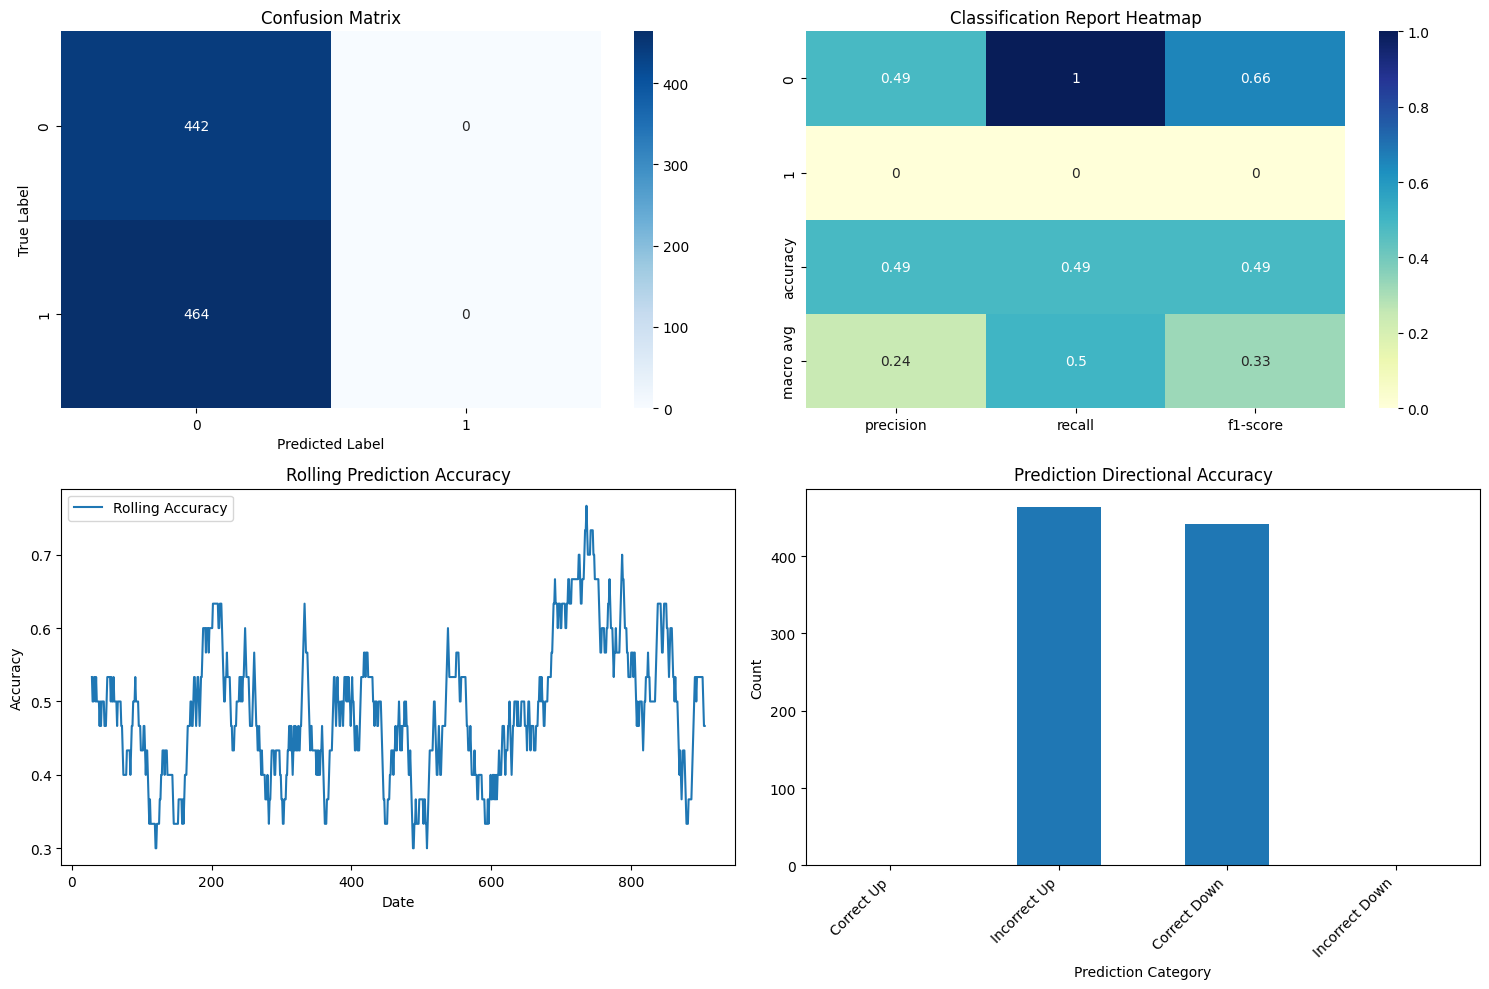


Results for Daily GARCH Prediction (p=2, q=1):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.0260
Mean Absolute Error: 0.1594
Directional Accuracy: 48.79%


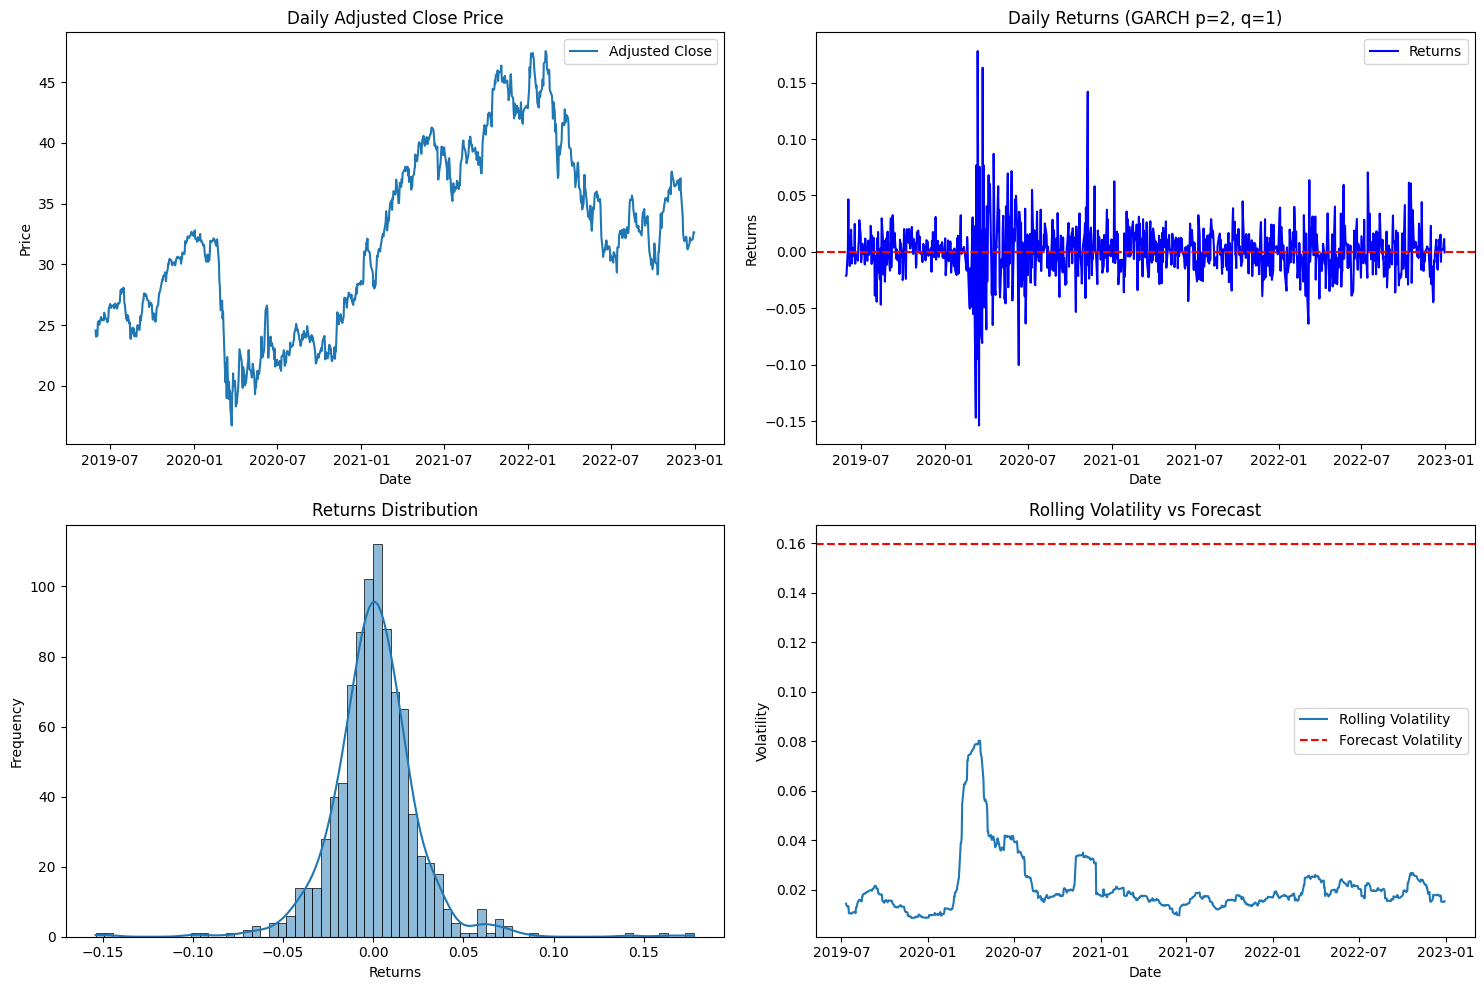

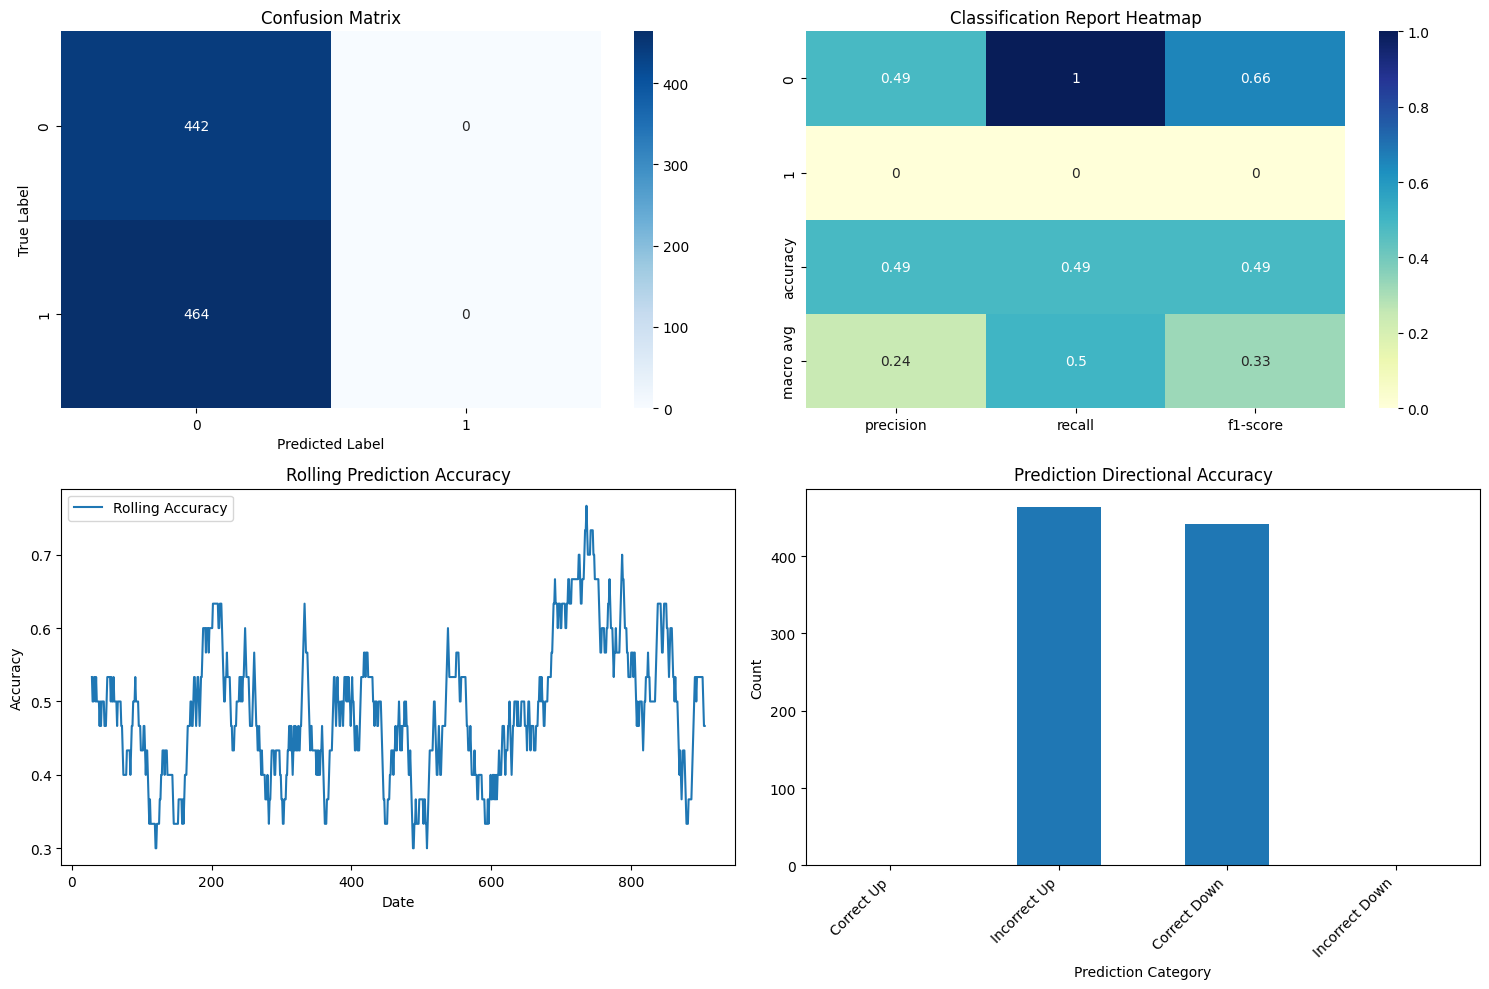


Results for Weekly GARCH Prediction (p=1, q=1):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.1508
Mean Absolute Error: 0.3849
Directional Accuracy: 43.09%


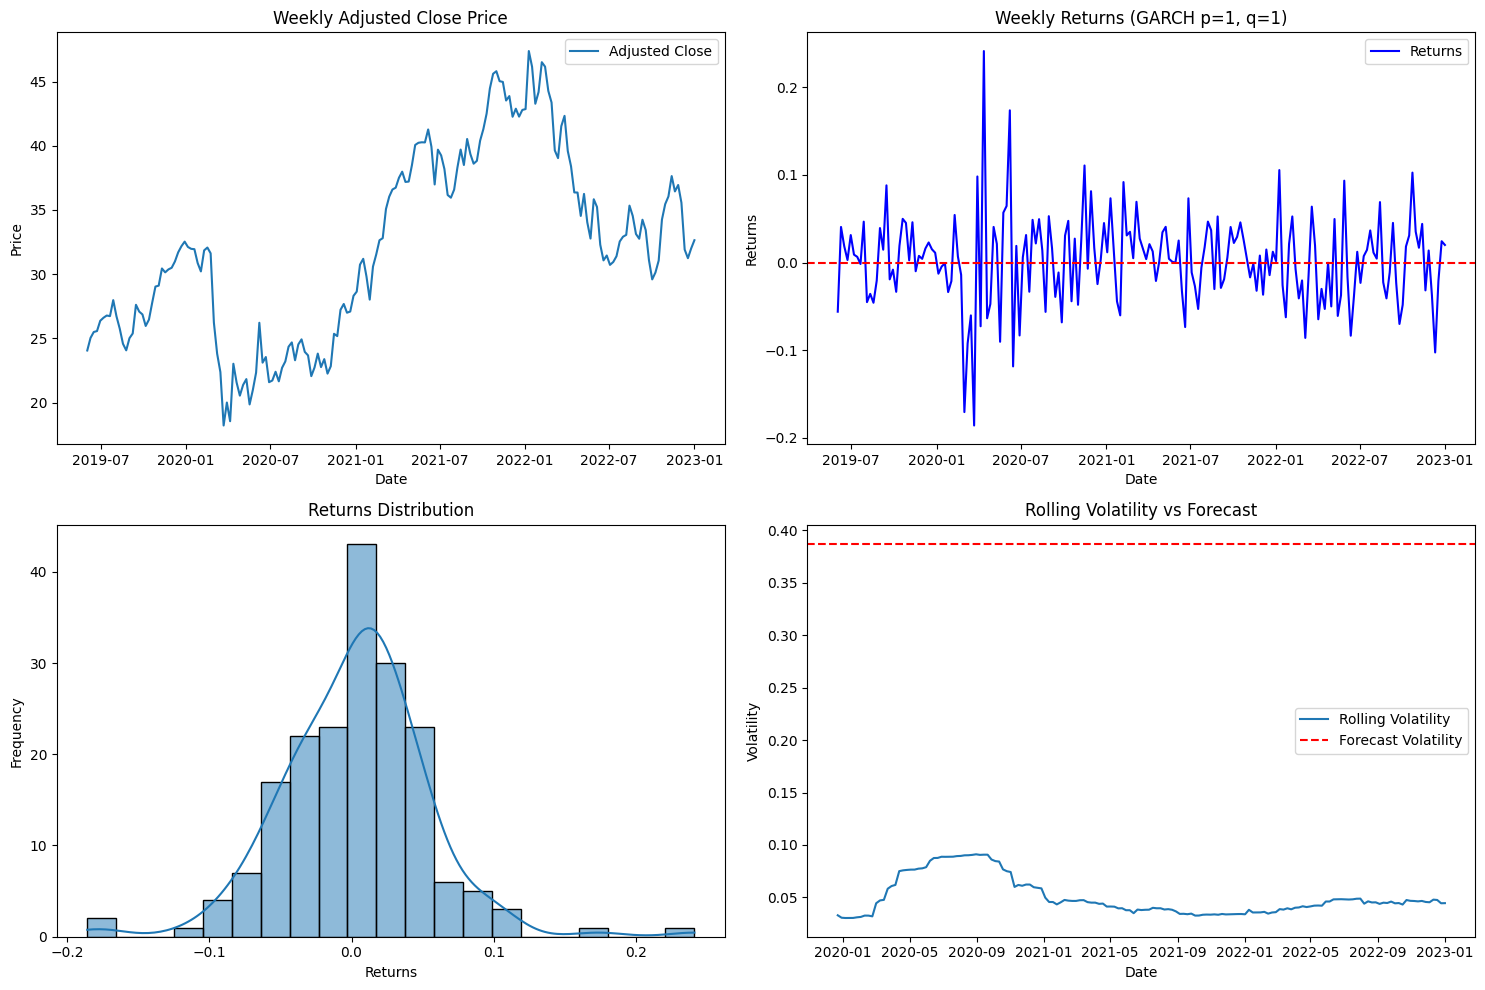

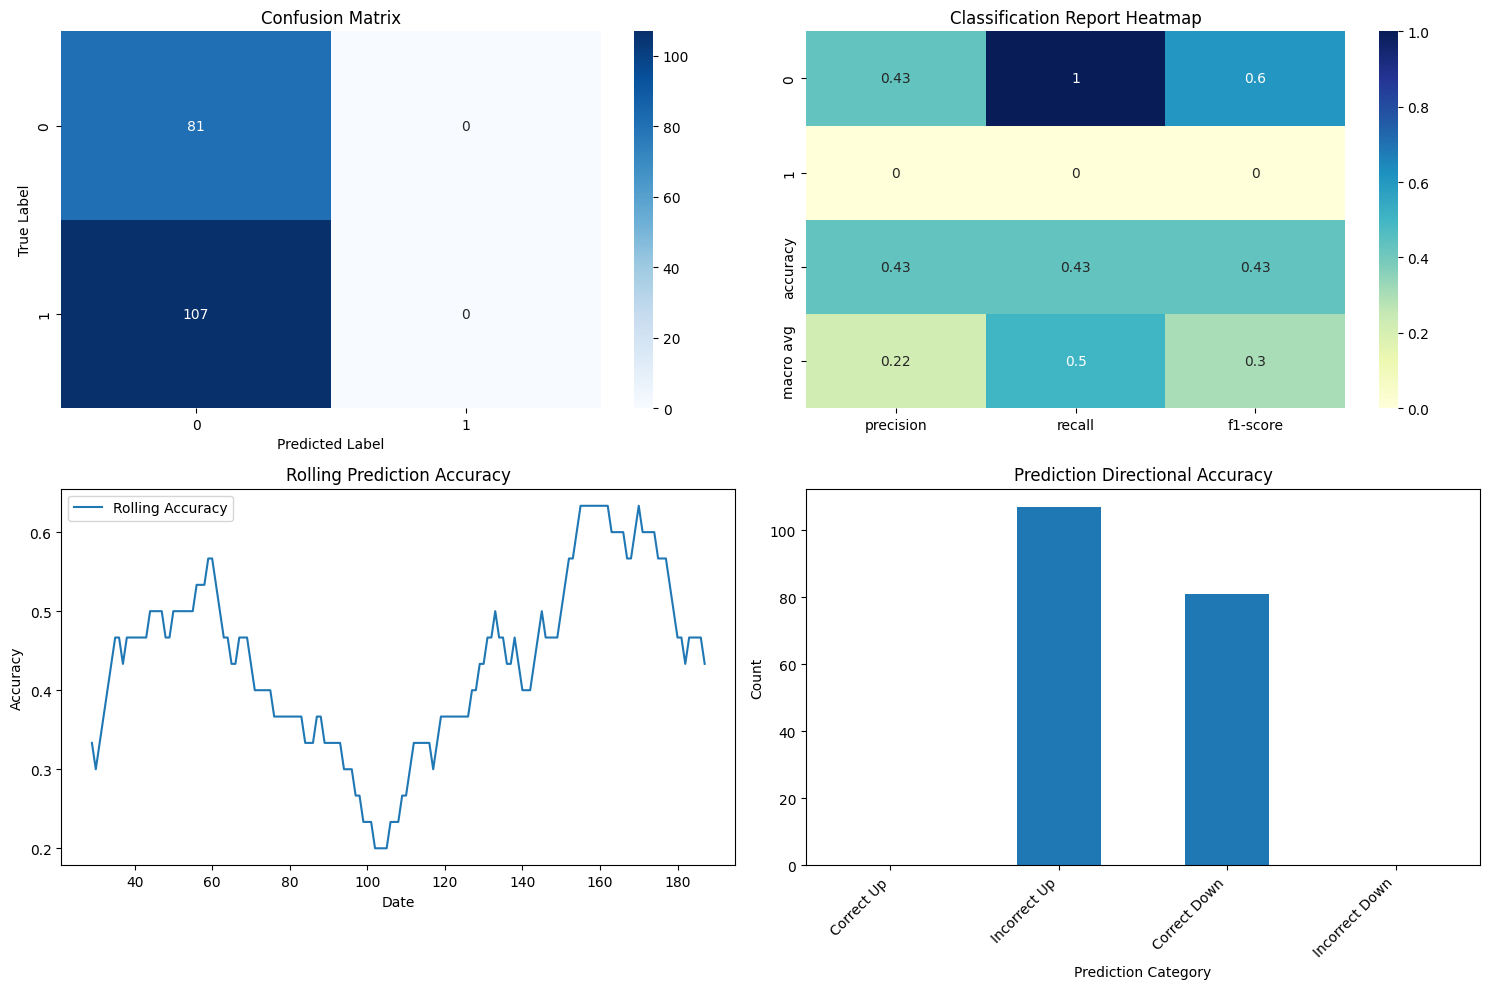


Results for Weekly GARCH Prediction (p=1, q=2):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.1508
Mean Absolute Error: 0.3849
Directional Accuracy: 43.09%


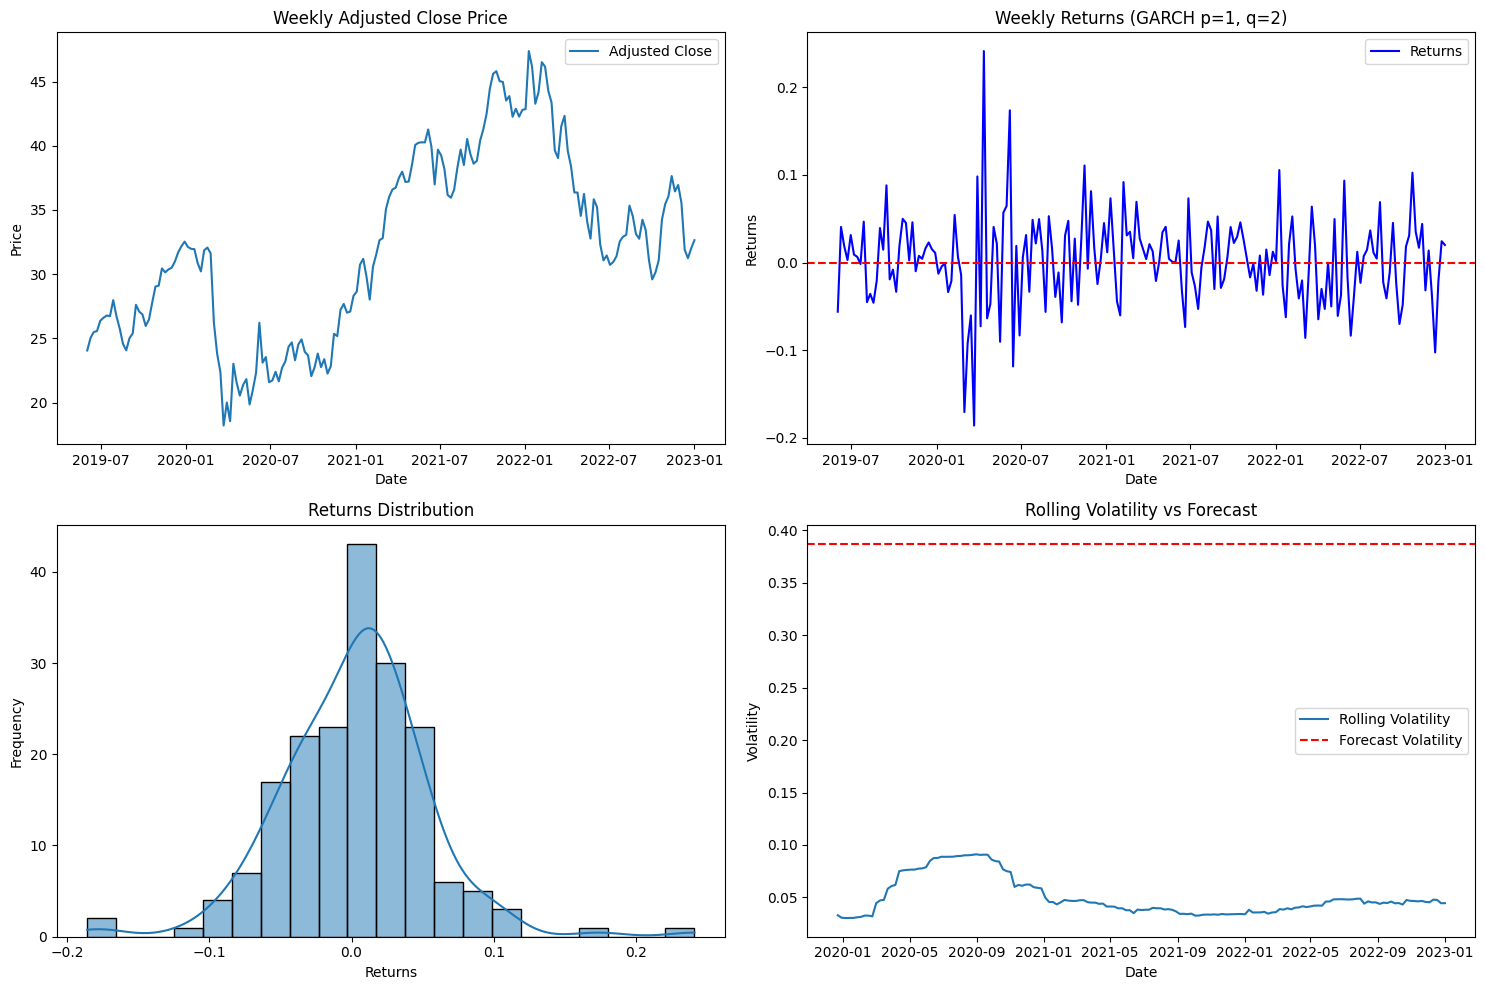

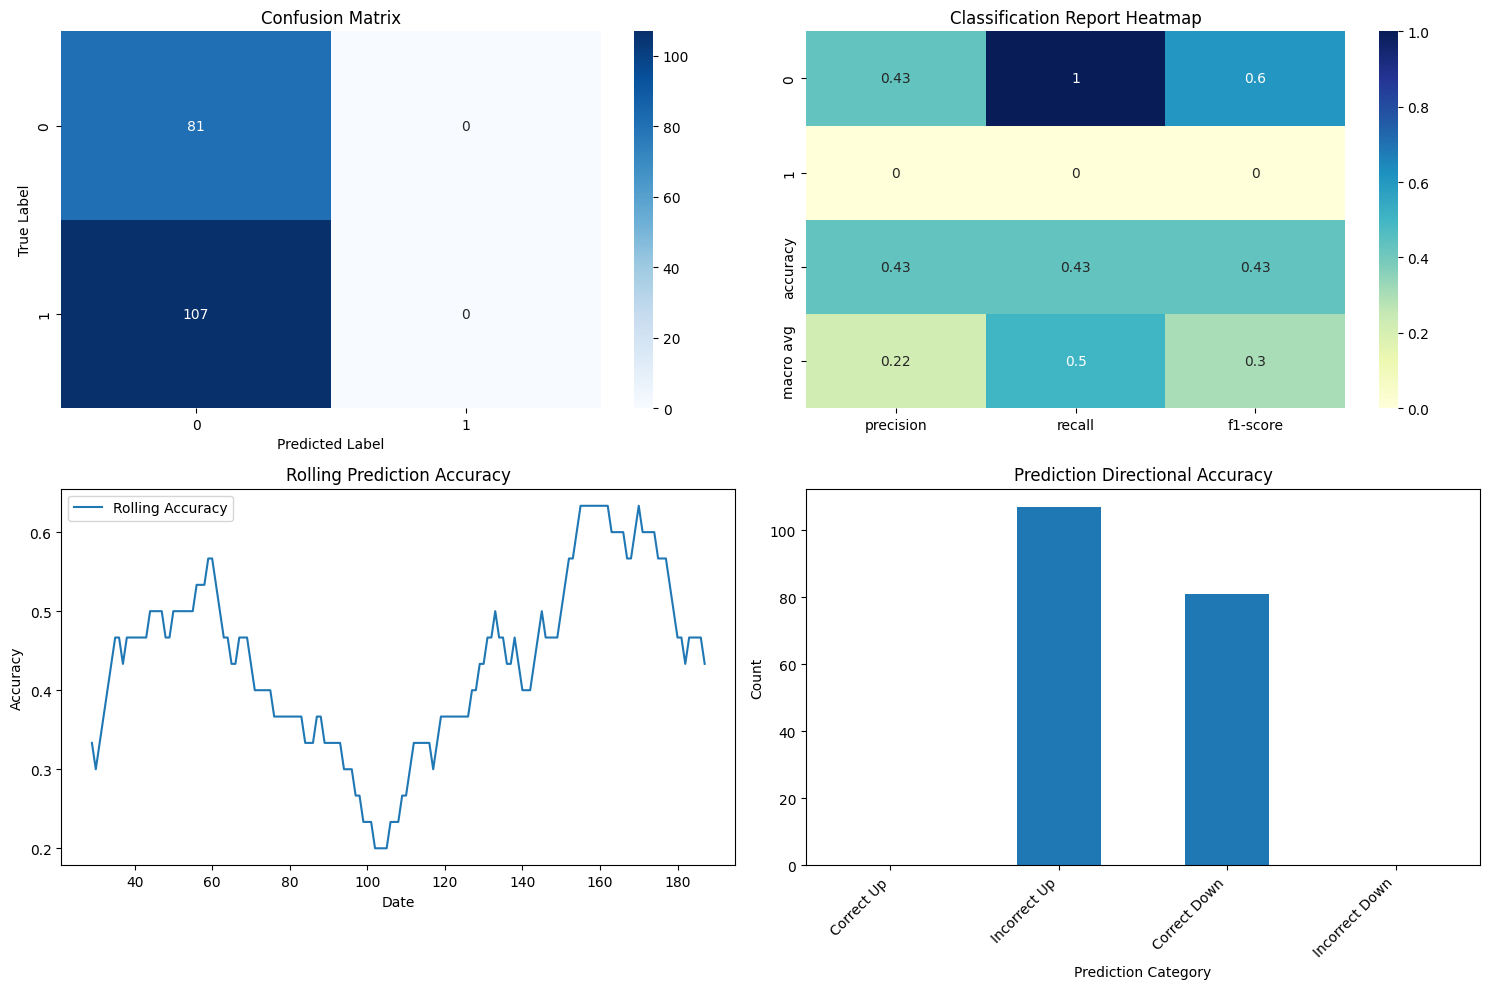


Results for Weekly GARCH Prediction (p=2, q=1):
Predicted Direction: Down
Volatility State: High Volatility
Confidence: 60.00%
Mean Squared Error: 0.1508
Mean Absolute Error: 0.3849
Directional Accuracy: 43.09%


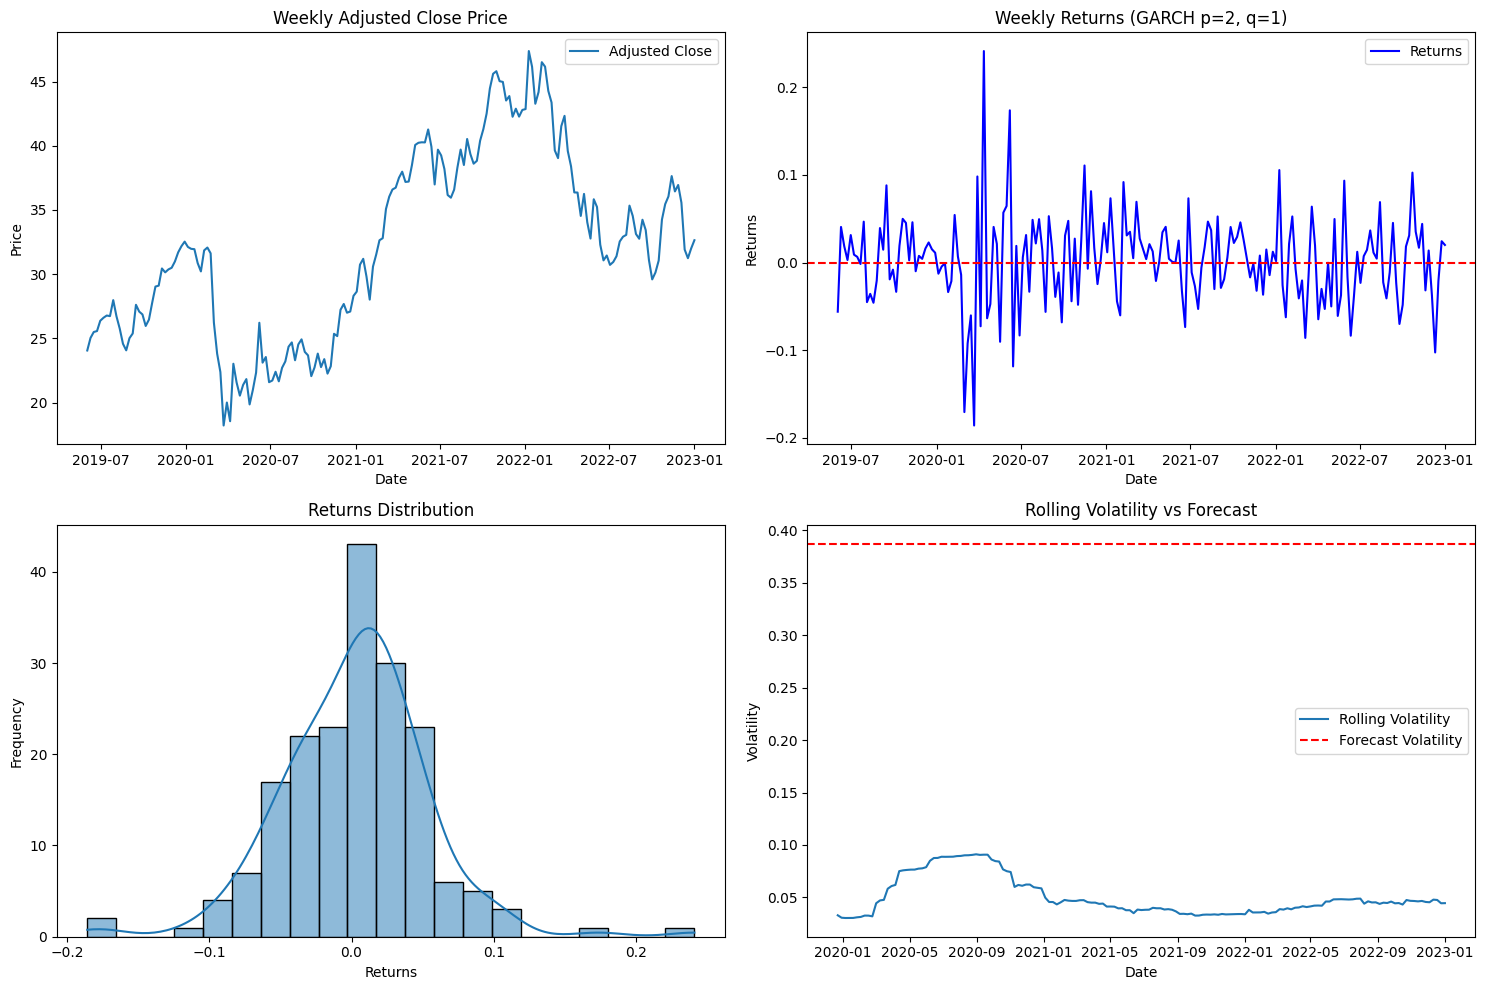

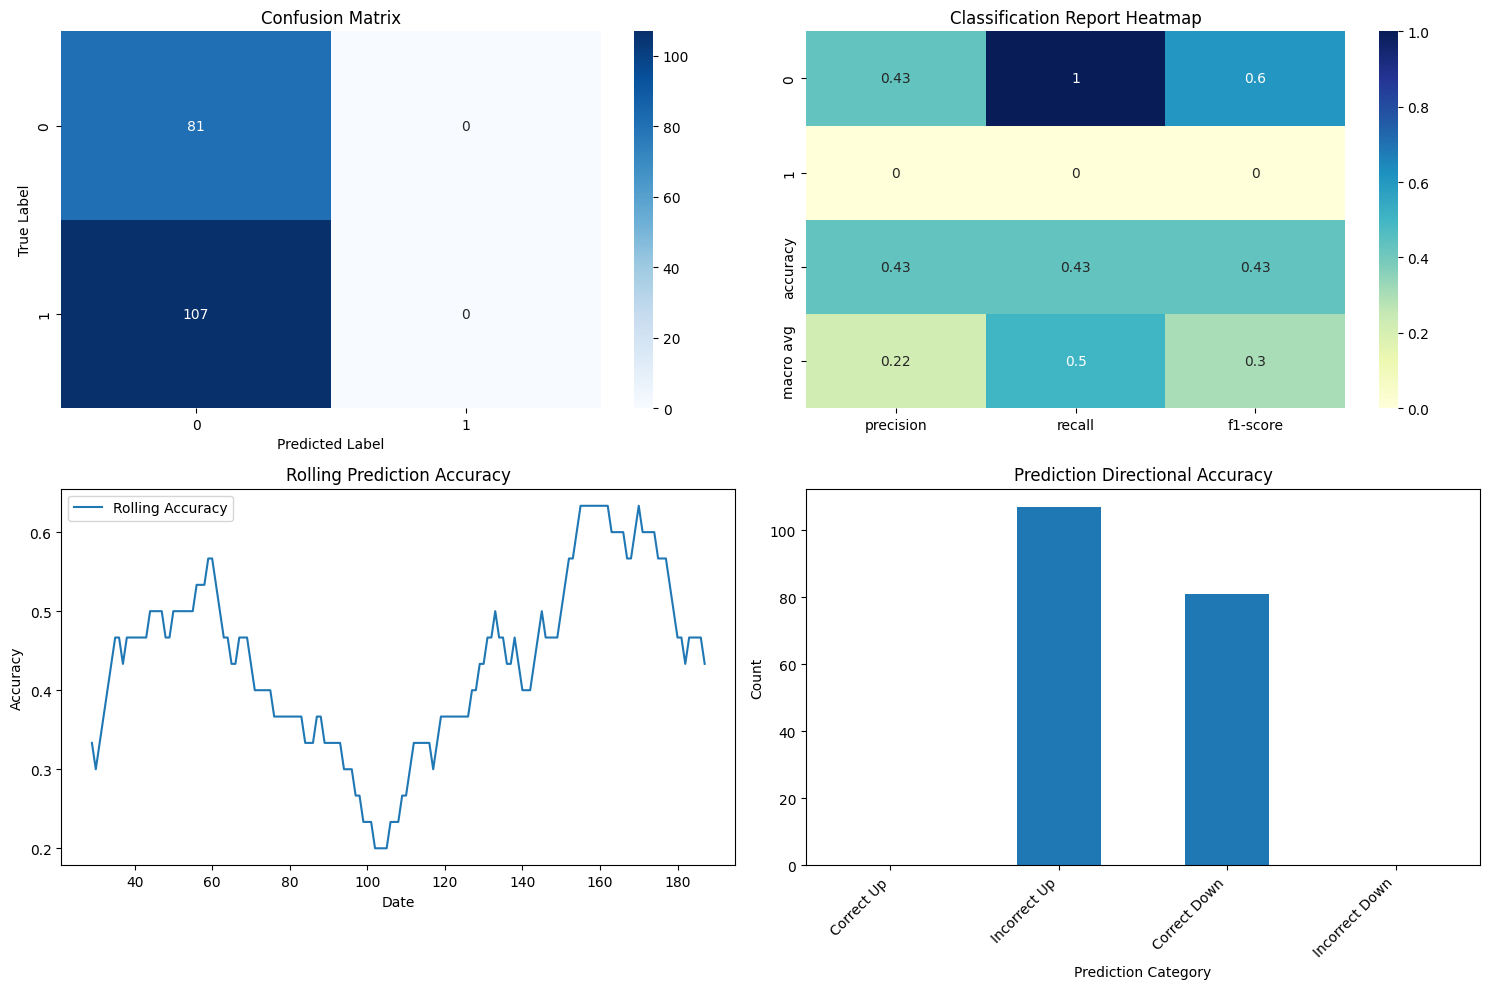


Summary for daily_p1_q1:
Direction: Down
Confidence: 60.00%
Accuracy: 48.79%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


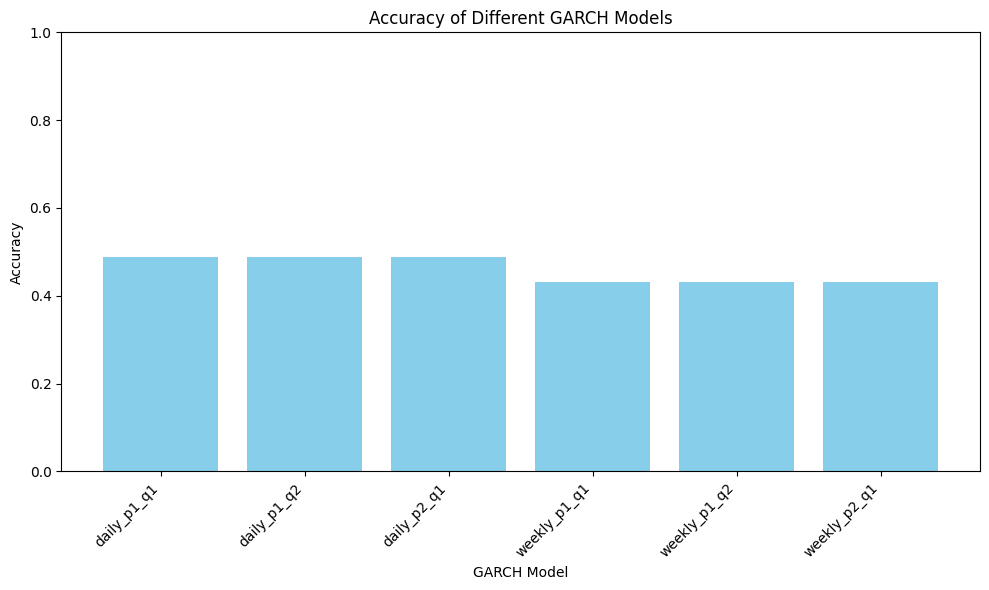


Summary for daily_p1_q2:
Direction: Down
Confidence: 60.00%
Accuracy: 48.79%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


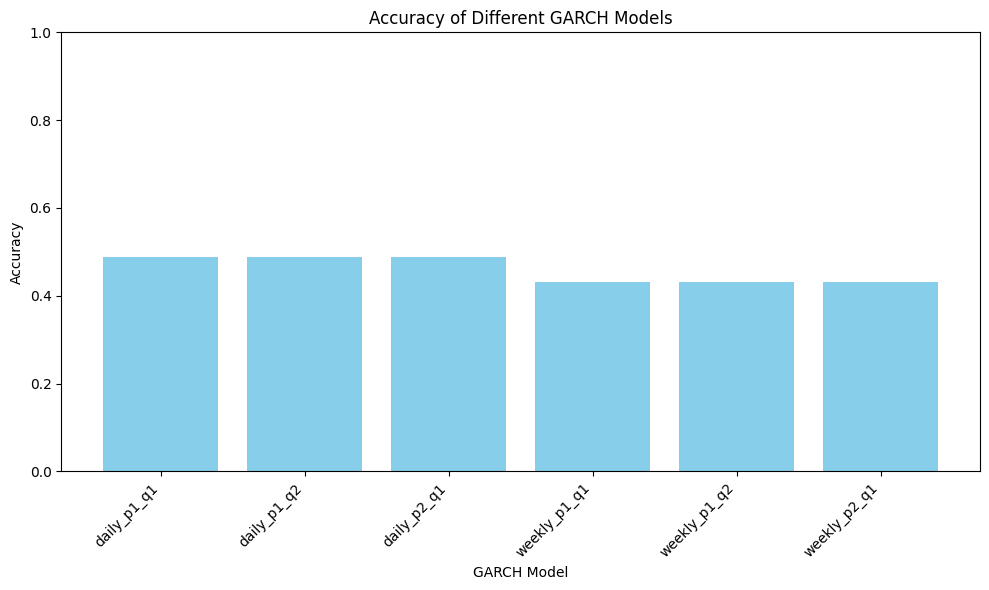


Summary for daily_p2_q1:
Direction: Down
Confidence: 60.00%
Accuracy: 48.79%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


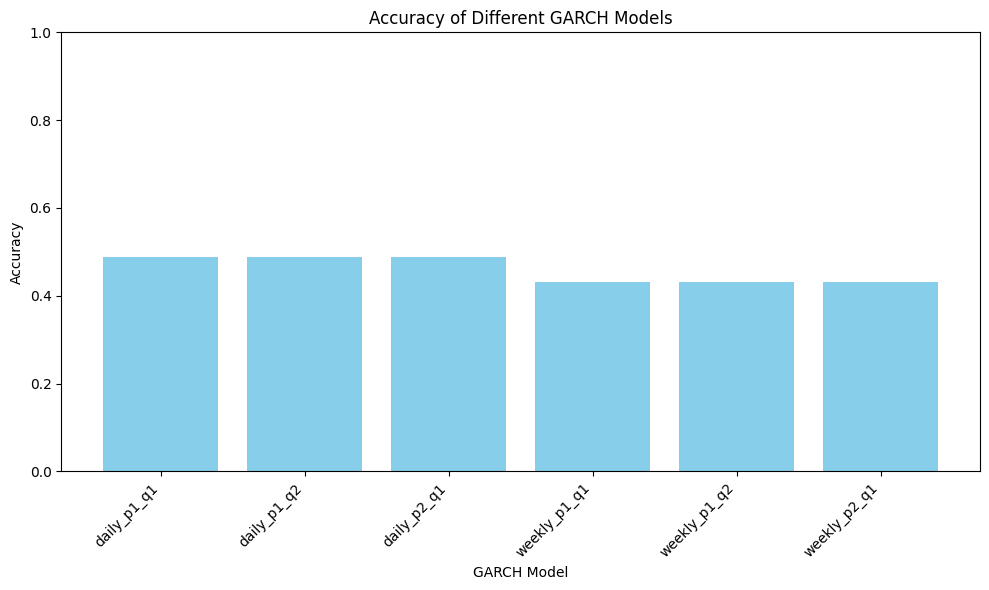


Summary for weekly_p1_q1:
Direction: Down
Confidence: 60.00%
Accuracy: 43.09%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


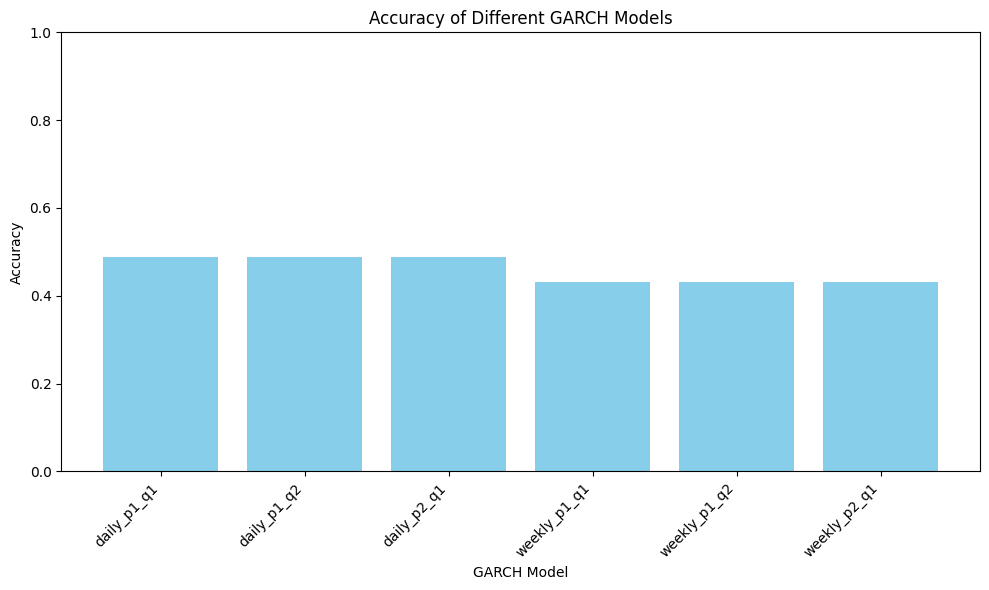


Summary for weekly_p1_q2:
Direction: Down
Confidence: 60.00%
Accuracy: 43.09%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


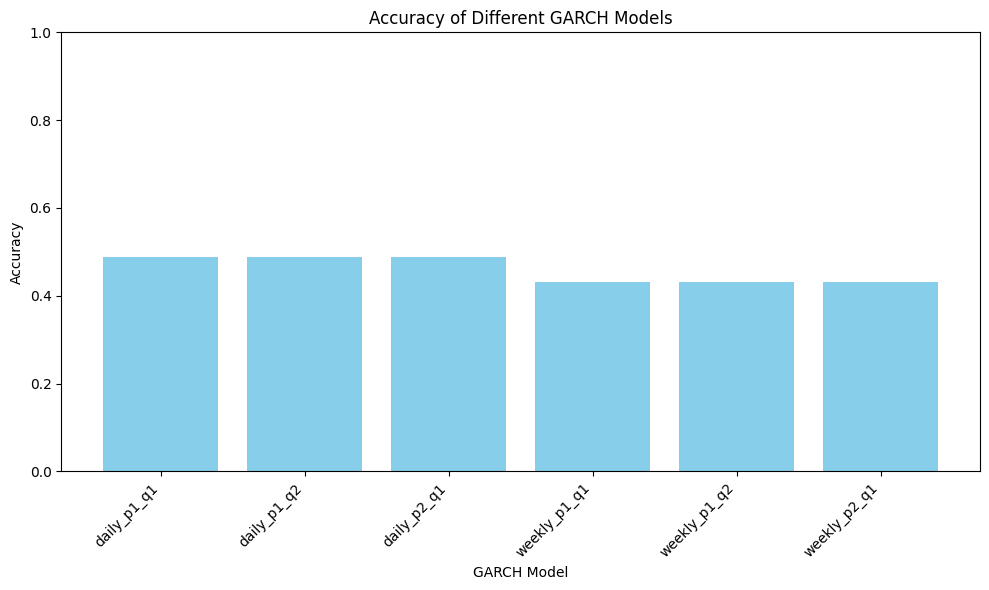


Summary for weekly_p2_q1:
Direction: Down
Confidence: 60.00%
Accuracy: 43.09%
GARCH Model Accuracies:
daily_p1_q1: 48.79%
daily_p1_q2: 48.79%
daily_p2_q1: 48.79%
weekly_p1_q1: 43.09%
weekly_p1_q2: 43.09%
weekly_p2_q1: 43.09%


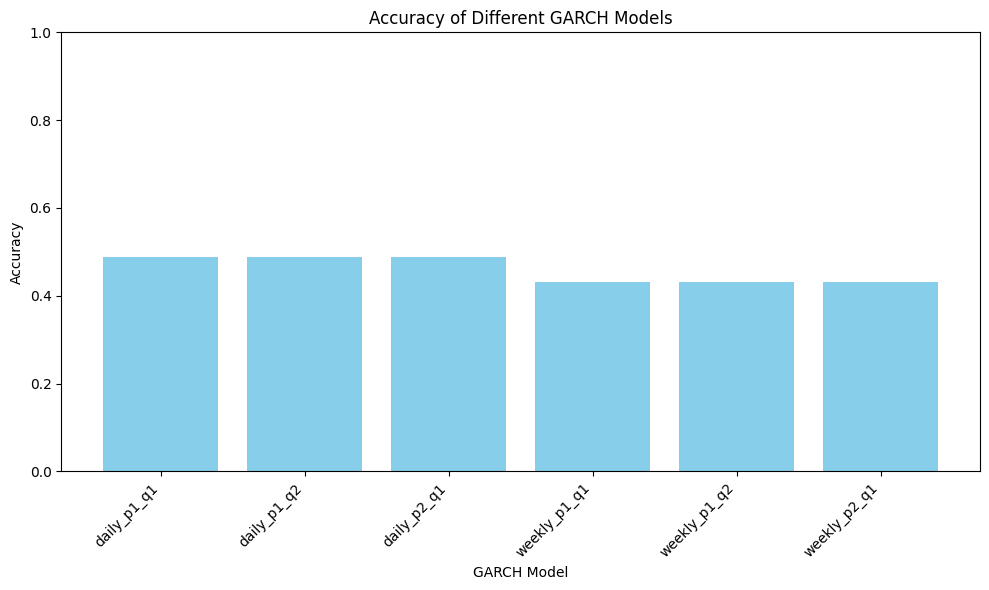

In [63]:
def main():
    try:
        # Read the data
        data = pd.read_csv('BAC.csv')
        
        # Ensure Date column is parsed
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Run GARCH experiments
        garch_results = run_garch_experiments(data)
        
        # Print summary results
        for key, result in garch_results.items():
            print(f"\nSummary for {key}:")
            print(f"Direction: {result['direction']}")
            print(f"Confidence: {result['confidence']:.2%}")
            print(f"Accuracy: {result['accuracy']:.2%}")
    
            plot_garch_accuracies(garch_results)
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()
    
        
main()